In [153]:
%matplotlib inline 
import numpy as np 
from matplotlib import pyplot as plt 
import h5py # used in the Data Visualization section 

from astropy.io import fits,ascii,votable
from astropy import units as u 
from astropy import constants as const
from astropy import table
from astropy.cosmology import Planck15,FlatLambdaCDM

# For ML application
from sklearn.cluster import KMeans
from sklearn import mixture
from itertools import combinations
from scipy.stats import ks_2samp

In [154]:
# Specify the version of the catalog and the folder with the input/output files
catversion = 'Farmer'  # this string can be either 'Classic' or 'Farmer'
dir_in = './'    #le fichier est dans le répertoire courant
dir_out = './'  # the directory where the output of this notebook will be stored



In [155]:
# Chose the SED fitting code: 
# set to 'lp' for LePhare results or
# set to 'ez' for EAZY
fitversion = 'lp'  

In [156]:
# Which type of photometric estimates to use? (suffix of the column name)
# This choice must be consistent with `catversion`,
# choices for Classic are: '_FLUX_APER2', '_FLUX_APER3', '_MAG_APER2,', '_MAG_APER3'
# choices for Farmer are '_FLUX' or '_MAG' 
flx = '_FLUX'  
flxerr = '_FLUXERR'  # catalog column for flux/mag error, just add 'ERR'
outflx = 'cgs' # 'cgs' or 'uJy'

In [157]:
# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4']  
filt_lambda = [0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796] 
# corresponding MW attenuation from Schelgel 
AlambdaDivEBV = [8.31,8.742,4.807,4.674,3.69,2.715,2.0,1.515,1.298,1.213,0.874,0.565,0.365,4.261,3.844,3.622,3.425,3.265,2.938,2.694,2.431,2.29,2.151,1.997,1.748,2.268,1.787,0.946,4.041,3.738,3.128,2.673,2.003,1.436,1.466,0.163,0.112,0.075,0.045]
# photometric offsets (not available for all filters, see Table 3 in W+21)
zpoff1 = [0.000,-0.352,-0.077,-0.023,0.073,0.101,0.038,0.036,0.086,0.054,0.017,-0.045,0.000,-0.104,-0.044,-0.021,-0.018,-0.045,-0.084,0.005,0.166,-0.023,-0.034,-0.032,-0.069,-0.010,-0.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.212,-0.219,0.000,0.000]  # Farmer+LePhare
zpoff2 = [0.000,-0.029,-0.006,0.053,0.128,0.127,0.094,0.084,0.100,0.049,0.025,-0.044,0.000,-0.013,-0.008,0.022,0.025,0.033,-0.032,0.031,0.208,-0.009,0.003,-0.015,-0.001,0.023,-0.021,-0.017,-0.075,0.000,0.123,0.035,0.051,0.000,0.095,-0.087,-0.111,0.000,0.000]  # Classic+LePhare
zpoff3 = [0.000,0.000,-0.196,-0.054,0.006,0.090,0.043,0.071,0.118,0.078,0.047,-0.034,0.000,-0.199,-0.129,-0.084,-0.073,-0.087,-0.124,0.004,0.154,-0.022,-0.030,-0.013,-0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.102,-0.044,0.000,0.000] # Farmer+EAZY
zpoff4 = [0.000,0.000,0.000,-0.021,0.055,0.124,0.121,0.121,0.145,0.085,0.057,-0.036,0.000,-0.133,-0.098,-0.046,-0.037,-0.038,-0.062,0.038,0.214,0.024,0.022,0.01,0.022,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.021,0.025,0.000,0.000] # Classic+EAZY
# create the dictionary
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4,AlambdaDivEBV[i],[zpoff1[i],zpoff2[i],zpoff3[i],zpoff4[i]]) for i in range(len(filt_name))}

In [158]:
# Upload the main catalogue
#cat0 = table.Table.read(dir_in+'COSMOS2020_{}_R1_v2.0.fits'.format(catversion.upper()),format='fits',hdu=1)

### je n'ai pas un fichier du même nom, je modifie en conséquence

cat0 = table.Table.read(dir_in+'COSMOS2020_{}_R1_v2.2_p3.fits'.format(catversion.upper()),format='fits',hdu=1)

In [159]:
# Create a mask to restrict the analysis to a subset of filters (optional)
filt_use = ['CFHT_ustar', 'CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2']
filt_mask = [i in filt_use for i in filt_name]

In [160]:
# Have a quick look inside the table
cat0[[0,-1]]

ID,ALPHA_J2000,DELTA_J2000,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,GROUP_ID,N_GROUP,MODEL_FLAG,SOLUTION_MODEL,FLAG_HSC,FLAG_SUPCAM,FLAG_UDEEP,FLAG_UVISTA,FLAG_COMBINED,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,CFHT_ustar_FLUX,CFHT_ustar_FLUXERR,CFHT_ustar_MAG,CFHT_ustar_MAGERR,CFHT_ustar_CHISQ,CFHT_ustar_DRIFT,CFHT_ustar_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_y_FLUX,HSC_y_FLUXERR,HSC_y_MAG,HSC_y_MAGERR,HSC_y_CHISQ,HSC_y_DRIFT,HSC_y_VALID,UVISTA_Y_FLUX,UVISTA_Y_FLUXERR,UVISTA_Y_MAG,UVISTA_Y_MAGERR,UVISTA_Y_CHISQ,UVISTA_Y_DRIFT,UVISTA_Y_VALID,UVISTA_J_FLUX,UVISTA_J_FLUXERR,UVISTA_J_MAG,UVISTA_J_MAGERR,UVISTA_J_CHISQ,UVISTA_J_DRIFT,UVISTA_J_VALID,UVISTA_H_FLUX,UVISTA_H_FLUXERR,UVISTA_H_MAG,UVISTA_H_MAGERR,UVISTA_H_CHISQ,UVISTA_H_DRIFT,UVISTA_H_VALID,UVISTA_Ks_FLUX,UVISTA_Ks_FLUXERR,UVISTA_Ks_MAG,UVISTA_Ks_MAGERR,UVISTA_Ks_CHISQ,UVISTA_Ks_DRIFT,UVISTA_Ks_VALID,UVISTA_NB118_FLUX,UVISTA_NB118_FLUXERR,UVISTA_NB118_MAG,UVISTA_NB118_MAGERR,UVISTA_NB118_CHISQ,UVISTA_NB118_DRIFT,UVISTA_NB118_VALID,SC_IB427_FLUX,SC_IB427_FLUXERR,SC_IB427_MAG,SC_IB427_MAGERR,SC_IB427_CHISQ,SC_IB427_DRIFT,SC_IB427_VALID,SC_IB464_FLUX,SC_IB464_FLUXERR,SC_IB464_MAG,SC_IB464_MAGERR,SC_IB464_CHISQ,SC_IB464_DRIFT,SC_IB464_VALID,SC_IA484_FLUX,SC_IA484_FLUXERR,SC_IA484_MAG,SC_IA484_MAGERR,SC_IA484_CHISQ,SC_IA484_DRIFT,SC_IA484_VALID,SC_IB505_FLUX,SC_IB505_FLUXERR,SC_IB505_MAG,SC_IB505_MAGERR,SC_IB505_CHISQ,SC_IB505_DRIFT,SC_IB505_VALID,SC_IA527_FLUX,SC_IA527_FLUXERR,SC_IA527_MAG,SC_IA527_MAGERR,SC_IA527_CHISQ,SC_IA527_DRIFT,SC_IA527_VALID,SC_IB574_FLUX,SC_IB574_FLUXERR,SC_IB574_MAG,SC_IB574_MAGERR,SC_IB574_CHISQ,SC_IB574_DRIFT,SC_IB574_VALID,SC_IA624_FLUX,SC_IA624_FLUXERR,SC_IA624_MAG,SC_IA624_MAGERR,SC_IA624_CHISQ,SC_IA624_DRIFT,SC_IA624_VALID,SC_IA679_FLUX,SC_IA679_FLUXERR,SC_IA679_MAG,SC_IA679_MAGERR,SC_IA679_CHISQ,SC_IA679_DRIFT,SC_IA679_VALID,SC_IB709_FLUX,SC_IB709_FLUXERR,SC_IB709_MAG,SC_IB709_MAGERR,SC_IB709_CHISQ,SC_IB709_DRIFT,SC_IB709_VALID,SC_IA738_FLUX,SC_IA738_FLUXERR,SC_IA738_MAG,SC_IA738_MAGERR,SC_IA738_CHISQ,SC_IA738_DRIFT,SC_IA738_VALID,SC_IA767_FLUX,SC_IA767_FLUXERR,SC_IA767_MAG,SC_IA767_MAGERR,SC_IA767_CHISQ,SC_IA767_DRIFT,SC_IA767_VALID,SC_IB827_FLUX,SC_IB827_FLUXERR,SC_IB827_MAG,SC_IB827_MAGERR,SC_IB827_CHISQ,SC_IB827_DRIFT,SC_IB827_VALID,SC_NB711_FLUX,SC_NB711_FLUXERR,SC_NB711_MAG,SC_NB711_MAGERR,SC_NB711_CHISQ,SC_NB711_DRIFT,SC_NB711_VALID,SC_NB816_FLUX,SC_NB816_FLUXERR,SC_NB816_MAG,SC_NB816_MAGERR,SC_NB816_CHISQ,SC_NB816_DRIFT,SC_NB816_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,IRAC_CH3_FLUX,IRAC_CH3_FLUXERR,IRAC_CH3_MAG,IRAC_CH3_MAGERR,IRAC_CH3_CHISQ,IRAC_CH3_DRIFT,IRAC_CH3_VALID,IRAC_CH4_FLUX,IRAC_CH4_FLUXERR,IRAC_CH4_MAG,IRAC_CH4_MAGERR,IRAC_CH4_CHISQ,IRAC_CH4_DRIFT,IRAC_CH4_VALID,ID_GALEX,GALEX_NUV_FLUX,GALEX_NUV_FLUXERR,GALEX_NUV_MAG,GALEX_NUV_MAGERR,GALEX_FUV_FLUX,GALEX_FUV_FLUXERR,GALEX_FUV_MAG,GALEX_FUV_MAGERR,ID_COSMOS2015,SPLASH_CH1_FLUX,SPLASH_CH1_FLUXERR,SPLASH_CH1_MAG,SPLASH_CH1_MAGERR,SPLASH_CH2_FLUX,SPLASH_CH2_FLUXERR,SPLASH_CH2_MAG,SPLASH_CH2_MAGERR,SPLASH_CH3_FLUX,SPLASH_CH3_FLUXERR,SPLASH_CH3_MAG,SPLASH_CH3_MAGERR,SPLASH_CH4_FLUX,SPLASH_CH4_FLUXERR,SPLASH_CH4_MAG,SPLASH_CH4_MAGERR,ID_ACS,ACS_F814W_MAG,ACS_F814W_MAGERR,ACS_F814W_FLUX,ACS_F814W_FLUXERR,ACS_A_WORLD,ACS_B_WORLD,ACS_THETA_WORLD,ACS_FWHM_WORLD,ACS_MU_MAX,ACS_MU_CLASS,ID_CHANDRA,ID_CLASSIC,lp_zBEST,lp_type,lp_zPDF,lp_zPDF_l68,lp_zPDF_u68,lp_zMinChi2,lp_chi2_best,lp_zp_2,lp_chi2_2,lp_NbFilt,lp_zq,lp

In [161]:
whichflag = 'COMBINED'  # you can try HSC, SUPCAM, UVISTA, UDEEP, COMBINED
print('The parent sample includes {} sources'.format(len(cat0)))
cat0 = cat0[cat0['FLAG_{}'.format(whichflag)]==0]
print('Now restricted to {} sources by using FLAG_COMBINED'.format(len(cat0)))

In [162]:
def mw_corr(tab_in,f_dict,ebv_col='EBV_MW',flx_col='_FLUX',flxerr_col='_FLUXERR',only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    ebv_col : name of the `tab_in` column containing the E(B-V) from Milky Way
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """
    
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    for c in ff:
        if verbose: print('remove MW attenuation in ',c+flx_col,f_dict[c][2])
        if c not in skip_filt:
            atten = f_dict[c][2]*tab[ebv_col]
            if flux:    tab[c+flx_col] *= np.power(10.,0.4*atten)
            else:    tab[c+flx_col] -= atten             
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab

In [163]:
# Here, the function creates a new table but
# it is also possible to overwrite the original table `cat0`
if catversion.lower()=='classic' and flx!='_FLUX' and flx!='_MAG':  
    # it means you are using aperture or AUTO flux/mag, which are not available for IRAC and GALEX 
    cat1 = mw_corr(cat0,filt_dict,flx_col=flx,flxerr_col=flxerr,only_filt=filt_use,skip_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'],out=True) # fluxes are  in uJy (zero point = 23.9)
    # therefore, IRAC and GALEX have to be taken into account separately:
    mw_corr(cat1,filt_dict,flx_col='_FLUX',flxerr_col='_FLUXERR',only_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV']) 
else:
    # otherwise, all filters have the same suffix
    cat1 = mw_corr(cat0,filt_dict,flx_col=flx,flxerr_col=flxerr,only_filt=filt_use,out=True)  # all bands have same column suffix

In [164]:
def aper_to_tot(tab_in,f_dict,flx_col='_FLUX',flxerr_col='_FLUXERR',scale_col='',out_col=None,only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info 
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    scale_col : name of the `tab_in` column containing the aper-to-total correction
    out_col : if defined, the rescaled photometry will be saved in a new column (otherwise it overwrites `flx_col`)
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`  
    """
    
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in 
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    for c in ff:
        if c not in skip_filt:

            if verbose and flux: print('rescale {} to total flux'.format(c+flx_col))
            if verbose and not flux: print('rescale {} to total mag'.format(c+flx_col))

            if flux:
                resc = np.power(10.,-0.4*tab[scale_col])
                if out_col:
                    tab[c+out_col] = tab[c+flx_col] * resc
                    tab[c+out_col+'ERR'] = tab[c+flxerr_col] * resc  # rescale also error bars not to alter the S/N ratio
                else:
                    tab[c+flx_col] *= resc
                    tab[c+flxerr_col] *= resc
            else:
                if out_col:
                    tab[c+out_col] = tab[c+flx_col] + tab[scale_col] 
                else:
                    tab[c+flx_col] += tab[scale_col]             
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab
    

In [165]:
# Can be applied only to aperture photometry (not to AUTO or Farmer)
if (flx[-1]=='2' or flx[-1]=='3'):
    aper_to_tot(cat1,filt_dict,flx_col=flx,flxerr_col=flxerr,out_col='_FLUX',
    only_filt=filt_use,skip_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'],
    scale_col='total_off'+flx[-1],verbose=True)


In [166]:
def photo_corr(tab_in,f_dict,versions=('Farmer','lp'),flx_col='_FLUX',only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    ebv_col : name of the `tab_in` column containing the E(B-V) from Milky Way
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    
    if versions[0]=='Farmer' and versions[1]=='lp': v=0
    elif versions[0]=='Farmer' and versions[1]=='ez': v=1
    elif versions[0]=='Classic' and versions[1]=='lp': v=2
    elif versions[0]=='Classic' and versions[1]=='ez': v=3
    else: 
        print("ERROR: is this catalog version real?", version)
        return
    
    for c in ff:
        if verbose: print(' apply photometric offset to ',c+flx_col)
        offset = f_dict[c][3][v]
        if c not in skip_filt and offset!=0.:
            if flux:  tab[c+flx_col] *= np.power(10.,-0.4*offset)
            else:  tab[c+flx_col] += offset              
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab

In [167]:
photo_corr(cat1,filt_dict,only_filt=filt_use,versions=(catversion,fitversion))

In [168]:
cat = cat1.copy()

cat.rename_column('lp_zBEST', 'photoz') 
cat.rename_column('ALPHA_J2000','alpha')
cat.rename_column('DELTA_J2000','delta')
cat.rename_column('ez_z_phot','z')

In [169]:
# optional: keep only the most commonly used columns (total FLUX, error bars, RA, DEC...)
#cat.keep_columns(['ID','ALPHA_J2000','DELTA_J2000']+
#                 [i+'_FLUX' for i in filt_use]+[i+'_FLUXERR' for i in filt_use]+
#                 ['lp_zBEST','lp_model','lp_age','lp_dust','lp_Attenuation','lp_zp_2','lp_zq','lp_type']+
#                 ['lp_MNUV','lp_MR','lp_MJ','lp_mass_med','lp_mass_med_min68','lp_mass_med_max68','lp_SFR_med','lp_mass_best'])

In [170]:
# optional: magnitudes in AB system
#m0 = +23.9  # fluxes in the catalog are in microJansky
#for b in filt_use:
#    mag = -2.5*np.log10(cat[b+'_FLUX'].data) + m0  # log of negative flux is masked
#    cat.add_column(mag.filled(np.nan),name=b+'_MAG')  # negative flux becomes NaN 

In [171]:
# flux conversion from uJy to erg/cm2/s/Hz
if outflx=='cgs':
    for b in filt_use:
        cat[b+'_FLUX'] *= 1e-29
        cat[b+'_FLUX'].unit = u.erg/u.cm/u.cm/u.s/u.Hz
        cat[b+'_FLUXERR'] *= 1e-29
        cat[b+'_FLUXERR'].unit = u.erg/u.cm/u.cm/u.s/u.Hz

In [172]:
### C'est bon , les données sont prêtes ###

In [173]:
cat[[0,-1]]

ID,alpha,delta,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,GROUP_ID,N_GROUP,MODEL_FLAG,SOLUTION_MODEL,FLAG_HSC,FLAG_SUPCAM,FLAG_UDEEP,FLAG_UVISTA,FLAG_COMBINED,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,CFHT_ustar_FLUX,CFHT_ustar_FLUXERR,CFHT_ustar_MAG,CFHT_ustar_MAGERR,CFHT_ustar_CHISQ,CFHT_ustar_DRIFT,CFHT_ustar_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_y_FLUX,HSC_y_FLUXERR,HSC_y_MAG,HSC_y_MAGERR,HSC_y_CHISQ,HSC_y_DRIFT,HSC_y_VALID,UVISTA_Y_FLUX,UVISTA_Y_FLUXERR,UVISTA_Y_MAG,UVISTA_Y_MAGERR,UVISTA_Y_CHISQ,UVISTA_Y_DRIFT,UVISTA_Y_VALID,UVISTA_J_FLUX,UVISTA_J_FLUXERR,UVISTA_J_MAG,UVISTA_J_MAGERR,UVISTA_J_CHISQ,UVISTA_J_DRIFT,UVISTA_J_VALID,UVISTA_H_FLUX,UVISTA_H_FLUXERR,UVISTA_H_MAG,UVISTA_H_MAGERR,UVISTA_H_CHISQ,UVISTA_H_DRIFT,UVISTA_H_VALID,UVISTA_Ks_FLUX,UVISTA_Ks_FLUXERR,UVISTA_Ks_MAG,UVISTA_Ks_MAGERR,UVISTA_Ks_CHISQ,UVISTA_Ks_DRIFT,UVISTA_Ks_VALID,UVISTA_NB118_FLUX,UVISTA_NB118_FLUXERR,UVISTA_NB118_MAG,UVISTA_NB118_MAGERR,UVISTA_NB118_CHISQ,UVISTA_NB118_DRIFT,UVISTA_NB118_VALID,SC_IB427_FLUX,SC_IB427_FLUXERR,SC_IB427_MAG,SC_IB427_MAGERR,SC_IB427_CHISQ,SC_IB427_DRIFT,SC_IB427_VALID,SC_IB464_FLUX,SC_IB464_FLUXERR,SC_IB464_MAG,SC_IB464_MAGERR,SC_IB464_CHISQ,SC_IB464_DRIFT,SC_IB464_VALID,SC_IA484_FLUX,SC_IA484_FLUXERR,SC_IA484_MAG,SC_IA484_MAGERR,SC_IA484_CHISQ,SC_IA484_DRIFT,SC_IA484_VALID,SC_IB505_FLUX,SC_IB505_FLUXERR,SC_IB505_MAG,SC_IB505_MAGERR,SC_IB505_CHISQ,SC_IB505_DRIFT,SC_IB505_VALID,SC_IA527_FLUX,SC_IA527_FLUXERR,SC_IA527_MAG,SC_IA527_MAGERR,SC_IA527_CHISQ,SC_IA527_DRIFT,SC_IA527_VALID,SC_IB574_FLUX,SC_IB574_FLUXERR,SC_IB574_MAG,SC_IB574_MAGERR,SC_IB574_CHISQ,SC_IB574_DRIFT,SC_IB574_VALID,SC_IA624_FLUX,SC_IA624_FLUXERR,SC_IA624_MAG,SC_IA624_MAGERR,SC_IA624_CHISQ,SC_IA624_DRIFT,SC_IA624_VALID,SC_IA679_FLUX,SC_IA679_FLUXERR,SC_IA679_MAG,SC_IA679_MAGERR,SC_IA679_CHISQ,SC_IA679_DRIFT,SC_IA679_VALID,SC_IB709_FLUX,SC_IB709_FLUXERR,SC_IB709_MAG,SC_IB709_MAGERR,SC_IB709_CHISQ,SC_IB709_DRIFT,SC_IB709_VALID,SC_IA738_FLUX,SC_IA738_FLUXERR,SC_IA738_MAG,SC_IA738_MAGERR,SC_IA738_CHISQ,SC_IA738_DRIFT,SC_IA738_VALID,SC_IA767_FLUX,SC_IA767_FLUXERR,SC_IA767_MAG,SC_IA767_MAGERR,SC_IA767_CHISQ,SC_IA767_DRIFT,SC_IA767_VALID,SC_IB827_FLUX,SC_IB827_FLUXERR,SC_IB827_MAG,SC_IB827_MAGERR,SC_IB827_CHISQ,SC_IB827_DRIFT,SC_IB827_VALID,SC_NB711_FLUX,SC_NB711_FLUXERR,SC_NB711_MAG,SC_NB711_MAGERR,SC_NB711_CHISQ,SC_NB711_DRIFT,SC_NB711_VALID,SC_NB816_FLUX,SC_NB816_FLUXERR,SC_NB816_MAG,SC_NB816_MAGERR,SC_NB816_CHISQ,SC_NB816_DRIFT,SC_NB816_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,IRAC_CH3_FLUX,IRAC_CH3_FLUXERR,IRAC_CH3_MAG,IRAC_CH3_MAGERR,IRAC_CH3_CHISQ,IRAC_CH3_DRIFT,IRAC_CH3_VALID,IRAC_CH4_FLUX,IRAC_CH4_FLUXERR,IRAC_CH4_MAG,IRAC_CH4_MAGERR,IRAC_CH4_CHISQ,IRAC_CH4_DRIFT,IRAC_CH4_VALID,ID_GALEX,GALEX_NUV_FLUX,GALEX_NUV_FLUXERR,GALEX_NUV_MAG,GALEX_NUV_MAGERR,GALEX_FUV_FLUX,GALEX_FUV_FLUXERR,GALEX_FUV_MAG,GALEX_FUV_MAGERR,ID_COSMOS2015,SPLASH_CH1_FLUX,SPLASH_CH1_FLUXERR,SPLASH_CH1_MAG,SPLASH_CH1_MAGERR,SPLASH_CH2_FLUX,SPLASH_CH2_FLUXERR,SPLASH_CH2_MAG,SPLASH_CH2_MAGERR,SPLASH_CH3_FLUX,SPLASH_CH3_FLUXERR,SPLASH_CH3_MAG,SPLASH_CH3_MAGERR,SPLASH_CH4_FLUX,SPLASH_CH4_FLUXERR,SPLASH_CH4_MAG,SPLASH_CH4_MAGERR,ID_ACS,ACS_F814W_MAG,ACS_F814W_MAGERR,ACS_F814W_FLUX,ACS_F814W_FLUXERR,ACS_A_WORLD,ACS_B_WORLD,ACS_THETA_WORLD,ACS_FWHM_WORLD,ACS_MU_MAX,ACS_MU_CLASS,ID_CHANDRA,ID_CLASSIC,photoz,lp_type,lp_zPDF,lp_zPDF_l68,lp_zPDF_u68,lp_zMinChi2,lp_chi2_best,lp_zp_2,lp_chi2_2,lp_NbFilt,lp_zq,lp_chiq,lp_modq,

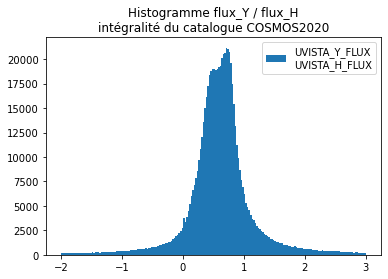

In [174]:
# 1er essai d'hist Y_H avec tout

Y_H = cat["UVISTA_Y_FLUX"] / cat["UVISTA_H_FLUX"]

plt.hist(Y_H , bins=200 , range=(-2,3) , label="UVISTA_Y_FLUX\nUVISTA_H_FLUX")
plt.legend()
plt.title("Histogramme flux_Y / flux_H\nintégralité du catalogue COSMOS2020")
plt.savefig("hist_flux_Y_H_tout_COSMOS2020.pdf")
plt.show()

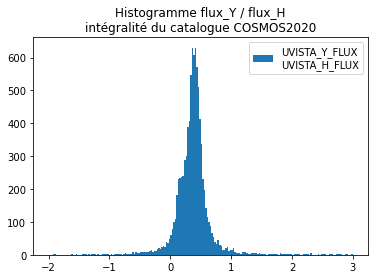

In [175]:
# 1er essai d'hist Y_H avec le masque sur les redshifts

mask = (cat["z"] >= 2.1 ) & (cat["z"] <= 2.2) 

Y_H = cat["UVISTA_Y_FLUX"][mask] / cat["UVISTA_H_FLUX"][mask]

plt.hist(Y_H , bins=200 , range=(-2,3) , label="UVISTA_Y_FLUX\nUVISTA_H_FLUX")
plt.legend()
plt.title("Histogramme flux_Y / flux_H\nintégralité du catalogue COSMOS2020")
plt.savefig("hist_flux_Y_H_tout_COSMOS2020.pdf")
plt.show()

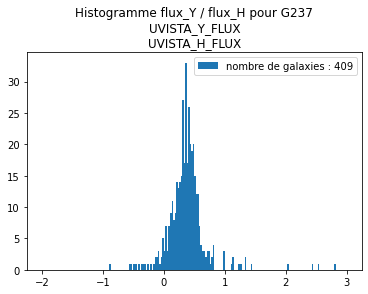

In [176]:
# 2eme essai, sélectionner G237

# Coordonnées de G237 :
alpha_G237 = 150.507                      
delta_G237 = 2.31204                     
size_G237 = 12 * 5.5 / (60*60)

alpha_max , alpha_min = alpha_G237 + (12+1)/60 , alpha_G237 - (12+1)/60   # +1 pour élargir légèrement
delta_max , delta_min = delta_G237 + (5.5+1)/60 , delta_G237 - (5.5+1)/60   # +1 pour élargir légèrement

#filtres


# Créer un masque booléen pour les conditions    principe des masks : tableau même taille de booléens
# il faut filtrer la position et les z

# suis-je bête ? il faut aller de -alpha_max à alpha_max , pas de alpha_G237 - alpha_max à alpha_G237 + alpha_max


mask_G237 = (cat["alpha"] >= alpha_min) & (cat["alpha"] <= alpha_max) & \
       (cat["delta"] >= delta_min) & (cat["delta"] <=  delta_max) & \
       (cat["z"] >= 2.1 ) & (cat["z"] <= 2.2)        # filtre des alpha , delta , z


Y_H_G237 = cat["UVISTA_Y_FLUX"][mask_G237] / cat["UVISTA_H_FLUX"][mask_G237]

print(Y_H_G237)

plt.hist(Y_H_G237 , bins=200 , range=(-2,3) , label="nombre de galaxies : {}".format(len(Y_H_G237)))
plt.legend()
plt.title("Histogramme flux_Y / flux_H pour G237\nUVISTA_Y_FLUX\nUVISTA_H_FLUX")
plt.savefig("hist_flux_Y_H_G237.pdf")
plt.show()

print(len(Y_H_G237) , "c'est mieux, c'est plus cohérent")


In [177]:
# 3 eme essai, faire les histo des 6 zones différentes du ciel

# définition des points

#x1 , y1 = 150.1 , 1.9
#x2 , y2 = 150. , 2.77
#x3 , y3 = 149.65 , 2.77
#x4 , y4 = 149.67 , 2
#x5 , y5 = 149.8 , 2.21
#x6 , y6 = 150.75 , 1.9

#up_alpha , up_delta = (12+1)/60 , (5.5+1)/60

# masques pour chaques zones

#alpha_m1 , alpha_M1 = x1 - up_alpha , x1 + up_alpha
#delta_m1 , delta_M1 = y1 - up_delta , y1 + up_delta

#alpha_m2 , alpha_M2 = x2 - up_alpha , x2 + up_alpha
#delta_m2 , delta_M2 = y2 - up_delta , y2 + up_delta

#alpha_m3 , alpha_M3 = x3 - up_alpha , x3 + up_alpha
#delta_m3 , delta_M3 = y3 - up_delta , y3 + up_delta

#alpha_m4 , alpha_M4 = x4 - up_alpha , x4 + up_alpha
#delta_m4 , delta_M4 = y4 - up_delta , y4 + up_delta

#alpha_m5 , alpha_M5 = x5 - up_alpha , x5 + up_alpha
#delta_m5 , delta_M5 = y5 - up_delta , y5 + up_delta

#alpha_m6 , alpha_M6 = x6 - up_alpha , x6 + up_alpha
#delta_m6 , delta_M6 = y6 - up_delta , y6 + up_delta



#mask1 = (cat["alpha"] >= x1 - up_alpha) & (cat["alpha"] <= x1 + up_alpha) & \
#       (cat["delta"] >= y1 - up_delta) & (cat["delta"] <= y1 + up_delta) & \
#       (cat["z"] >= 2 ) & (cat["z"] <= 2.3)

#mask2 = (cat["alpha"] >= x2 - up_alpha) & (cat["alpha"] <= x2 + up_alpha) & \
#       (cat["delta"] >= y2 - up_delta) & (cat["delta"] <= y2 + up_delta) & \
#       (cat["z"] >= 2 ) & (cat["z"] <= 2.3)

#mask3 = (cat["alpha"] >= x3 - up_alpha) & (cat["alpha"] <= x3 + up_alpha) & \
#       (cat["delta"] >= y3 - up_delta) & (cat["delta"] <= y3 + up_delta) & \
#       (cat["z"] >= 2 ) & (cat["z"] <= 2.3)

#mask4 = (cat["alpha"] >= x4 - up_alpha) & (cat["alpha"] <= x4 + up_alpha) & \
#       (cat["delta"] >= y4 - delta_max) & (cat["delta"] <= y4 + delta_max) & \
#       (cat["z"] >= 2 ) & (cat["z"] <= 2.3)

#mask5 = (cat["alpha"] >= x5 - up_alpha) & (cat["alpha"] <= x5 + up_alpha) & \
#       (cat["delta"] >= y5 - up_delta) & (cat["delta"] <= y5 + up_delta) & \
#       (cat["z"] >= 2 ) & (cat["z"] <= 2.3)

#mask6 = (cat["alpha"] >= x6 - up_alpha) & (cat["alpha"] <= x6 + up_alpha) & \
#       (cat["delta"] >= y6 - up_delta) & (cat["delta"] <= y6 + up_delta) & \
#       (cat["z"] >= 2 ) & (cat["z"] <= 2.3)

# calcul des rapports

#Y_H_1 = cat["UVISTA_Y_FLUX"][mask1] / cat["UVISTA_H_FLUX"][mask1]
#Y_H_2 = cat["UVISTA_Y_FLUX"][mask2] / cat["UVISTA_H_FLUX"][mask2]
#Y_H_3 = cat["UVISTA_Y_FLUX"][mask3] / cat["UVISTA_H_FLUX"][mask3]
#Y_H_4 = cat["UVISTA_Y_FLUX"][mask4] / cat["UVISTA_H_FLUX"][mask4]
#Y_H_5 = cat["UVISTA_Y_FLUX"][mask5] / cat["UVISTA_H_FLUX"][mask5]
#Y_H_6 = cat["UVISTA_Y_FLUX"][mask6] / cat["UVISTA_H_FLUX"][mask6]

# Création de la grille de sous-graphiques
#fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Tracé du premier histogramme
#axs[0, 0].hist(Y_H_1 , bins=200 , range=(-2,3))
#axs[0, 0].set_title("région 1")
#axs[0, 0].legend(["$\\alpha$ = {}\n$\\delta$ = {}".format(x1,y1)])

# Tracé du deuxième histogramme
#axs[0, 1].hist(Y_H_2 , bins=200 , range=(-2,3))
#axs[0, 1].set_title("région 2")
#axs[0, 1].legend(["$\\alpha$ = {}\n$\\delta$ = {}".format(x2,y2)])

# Tracé du troisième histogramme
#axs[0, 2].hist(Y_H_3 , bins=200 , range=(-2,3))
#axs[0, 2].set_title("région 3")
#axs[0, 2].legend(["$\\alpha$ = {}\n$\\delta$ = {}".format(x3,y3)])

# Tracé du quatrième histogramme
#axs[1, 0].hist(Y_H_4 , bins=200 , range=(-2,3))
#axs[1, 0].set_title("région 4")
#axs[1, 0].legend(["$\\alpha$ = {}\n$\\delta$ = {}".format(x4,y4)])

# Tracé du cinquième histogramme
#axs[1, 1].hist(Y_H_5 , bins=200 , range=(-2,3))
#axs[1, 1].set_title("région 5")
#axs[1, 1].legend(["$\\alpha$ = {}\n$\\delta$ = {}".format(x5,y5)])

# Tracé du sixième histogramme
#axs[1, 2].hist(Y_H_6 , bins=200 , range=(-2,3))
#axs[1, 2].set_title("région 6")
#axs[1, 2].legend(["$\\alpha$ = {}\n$\\delta$ = {}".format(x6,y6)])

# Titre global
#plt.suptitle("Histogrammes Y_H\npour différentes régions couvertes par COSMOS2020")

# Ajustement des espacements entre les sous-graphiques
#plt.tight_layout()

#plt.savefig("hist_flux_Y_H_regions.pdf")
#plt.show()

#print(len(Y_H_1),len(Y_H_2),len(Y_H_3))

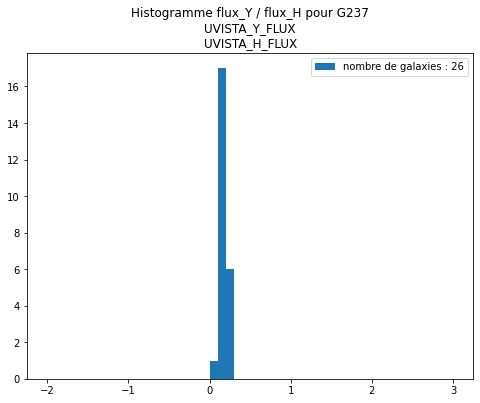

In [178]:
# Matching avec les coordonées de Mari

from astropy.coordinates import SkyCoord
import astropy.units as u

# Créer les coordonnées SkyCoord pour cat
cat_coords = SkyCoord(ra=cat['alpha'], dec=cat['delta'], unit='deg')

# Créer les coordonnées SkyCoord pour galaxies_G237
galaxies_G237 = [np.loadtxt('galax_G237.txt')[:, -3], np.loadtxt('galax_G237.txt')[:, -2]]
galaxies_coords = SkyCoord(ra=galaxies_G237[0], dec=galaxies_G237[1], unit='deg')

# Effectuer le matching en utilisant une boucle
idx = []
d2d = []
threshold = 0.5 * u.arcsec

for galaxy_coord in galaxies_coords:
    sep_constraint = cat_coords.separation(galaxy_coord) < threshold
    if np.any(sep_constraint):
        idx.append(np.where(sep_constraint)[0][0])
        d2d.append(cat_coords[idx[-1]].separation(galaxy_coord))

# Sélectionner les lignes correspondantes dans cat
matched_cat = cat[idx]

# Afficher les lignes correspondantes
print(matched_cat, '\n', len(matched_cat['alpha']))

Y_H_G237 = matched_cat["UVISTA_Y_FLUX"] / matched_cat["UVISTA_H_FLUX"]

fig = plt.figure(figsize=(8, 6))

plt.hist(Y_H_G237 , bins=50 , range=(-2,3) , label="nombre de galaxies : {}".format(len(Y_H_G237)))
plt.legend()
plt.title("Histogramme flux_Y / flux_H pour G237\nUVISTA_Y_FLUX\nUVISTA_H_FLUX")
plt.savefig("hist_flux_Y_H_G237_matching.pdf")
plt.show()

print(len(Y_H_G237) , '\n{}'.format(len(Y_H_G237)))

# Il est important que cette cellule soit exécuter avant celle qui fait les hist des régions
# sinon, les ks test pris en compte sont ceux de la sélection par l'ellipse (pas ce que je veux pour le moment)

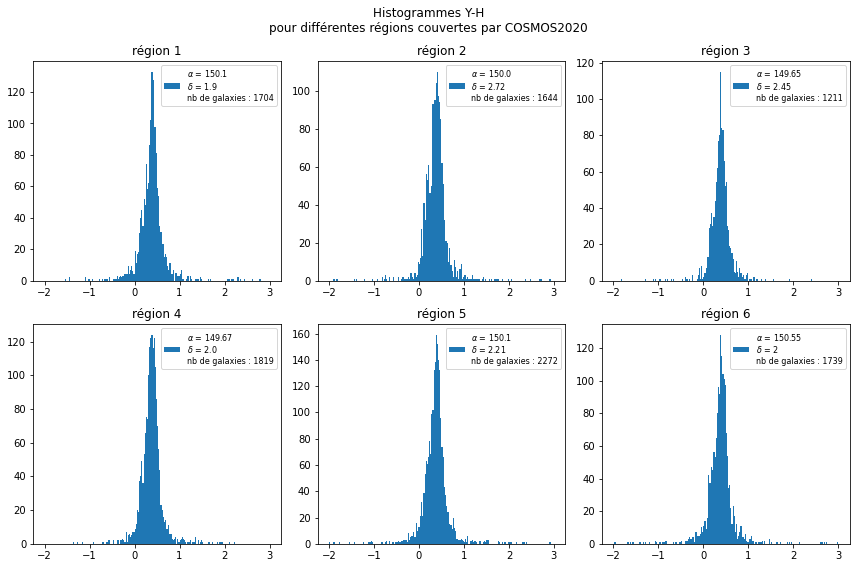

In [179]:
### VERSION COMPACT

# initialisation de la liste des Y_H et tableau des ks test
Y_Hs = []
KS = []

# Définition des points
points = [
    (150.1, 1.9),
    (150.0, 2.72),
    (149.65, 2.45),
    (149.67, 2.0),
    (150.1, 2.21),
    (150.55, 2)
]

up_alpha = (12 + 1) / 60
up_delta = (5.5 + 1) / 60

# Création de la grille de sous-graphiques
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, (x, y) in enumerate(points, 1):
    # Calcul des bornes des masques
    alpha_min = x - up_alpha
    alpha_max = x + up_alpha
    delta_min = y - up_delta
    delta_max = y + up_delta

    # Création du masque
    mask = (cat["alpha"] >= alpha_min) & (cat["alpha"] <= alpha_max) & \
           (cat["delta"] >= delta_min) & (cat["delta"] <= delta_max) & \
           (cat["z"] >= 2.) & (cat["z"] <= 2.3)

    # Calcul des rapports Y_H
    Y_H = cat["UVISTA_Y_FLUX"][mask] / cat["UVISTA_H_FLUX"][mask]
    #stockage dans une liste
    Y_Hs.append(Y_H)
    KS.append(ks_2samp(Y_H_G237,Y_H))

    # Tracé de l'histogramme correspondant (wouha stylé je n'y aurais jamais pensé)
    row = (i - 1) // 3
    col = (i - 1) % 3
    axs[row, col].hist(Y_H, bins=200, range=(-2, 3))
    axs[row, col].set_title("région {}".format(i))
    axs[row, col].legend(["$\\alpha$ = {}\n$\\delta$ = {}\nnb de galaxies : {}".format(x, y , len(Y_H))] , fontsize=8)

# Titre global
plt.suptitle("Histogrammes Y-H\npour différentes régions couvertes par COSMOS2020")

# Ajustement des espacements entre les sous-graphiques
plt.tight_layout()

plt.savefig("hist_flux_Y_H_regions.pdf")
plt.show()

# Sauvegarder la sortie standard actuelle (console)
sortie_standard = sys.stdout

# Rediriger la sortie vers le fichier .txt
import sys
fichier_txt = open("KS_test_hist_Y_H.txt", "w")
sys.stdout = fichier_txt


# Votre boucle for ici
for i in range(len(KS)):
    print("KS test entre G237 et région {} : D = {}   p-value = {}".format(i+1,KS[i][0],KS[i][1]))

# Rétablir la sortie standard (console)
sys.stdout = sortie_standard

# Fermer le fichier
fichier_txt.close()

print('\n')

for i in range(len(Y_Hs)):
    for j in range(len(Y_Hs)):
        if j > i:
            blou = ks_2samp(Y_Hs[i],Y_Hs[j])
            print("KS test entre la région {} et la région {} : D = {}   p-value = {}".format(i+1,j+1,blou[0],blou[1]))



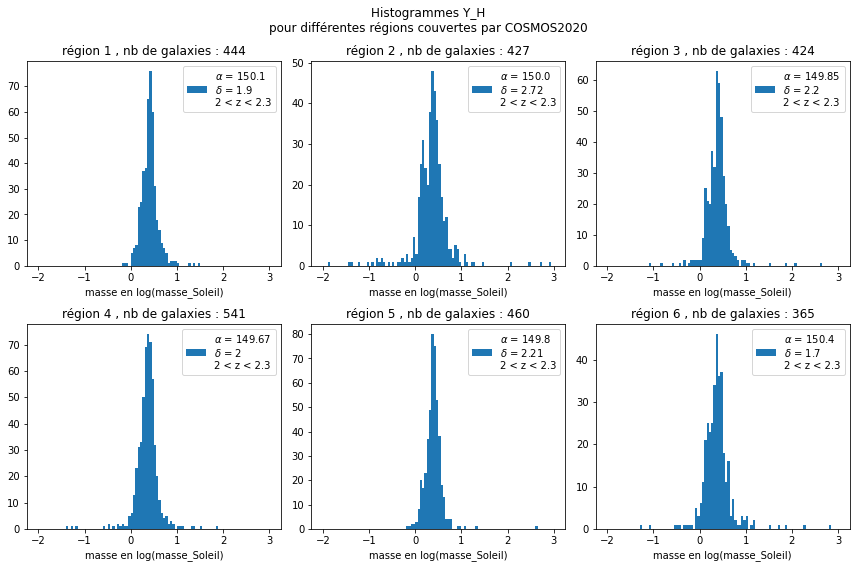

In [180]:
# Maintenant, j'essaie de matcher avec les autres zones

#Ce n'est pas très utile ni même intéressant

points = [
    [150.1, 1.9],
    [150., 2.72],
    [149.85, 2.2],
    [149.67, 2],
    [149.8, 2.21],
    [150.4, 1.7]
]

Y_Hs = []
KS = []

# Autres parties de votre code...

# Création de la grille de sous-graphiques
num_points = len(points)
num_cols = 3  # Nombre de colonnes de sous-graphiques
num_rows = (num_points + num_cols - 1) // num_cols  # Nombre de lignes de sous-graphiques

fig1, axs1 = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Traçage des histogrammes pour chaque point
for i, point in enumerate(points):
    ax = axs1[i // num_cols, i % num_cols]  # Sélection du sous-graphique correspondant

    # Création des coordonnées du point
    point_coord = SkyCoord(point[0], point[1], unit='deg')

    # Création des coordonnées du tableau cat
    cat_coords = SkyCoord(cat['alpha'], cat['delta'], unit='deg')

    # Calcul des distances
    distances = cat_coords.separation(point_coord)

    # Filtre des lignes
    radius = 5 * u.arcmin
    mask = (distances < radius) & (cat['z'] >= 2.) & (cat['z'] <= 2.3)
    filtered_cat = cat[mask]

    Y_H = filtered_cat["UVISTA_Y_FLUX"] / filtered_cat["UVISTA_H_FLUX"]
    Y_Hs.append(Y_H)
    KS.append(ks_2samp(Y_H_G237,Y_H)) #!!! il faut bien excuter les cellules du notebook dans le bon ordre

    # Traçage de l'histogramme
    ax.hist(Y_H, bins=100 , range=(-2,3) )  # Ajustez les paramètres de l'histogramme selon vos besoins
    ax.set_title("région {} , nb de galaxies : {}".format(i + 1, len(Y_H)))  # Titre du sous-graphique
    ax.set_xlabel("masse en log(masse_Soleil)")
    ax.legend(["$\\alpha$ = {}\n$\\delta$ = {}\n2 < z < 2.3".format(*points[i])])
    print(len(Y_H))

plt.suptitle("Histogrammes Y_H\npour différentes régions couvertes par COSMOS2020")

# Réglages de la mise en page
plt.tight_layout()

plt.savefig("hist_flux_Y_H_matching.pdf")

# Affichage du graphique
plt.show(fig1)



import sys

# Définition du nom du fichier de sortie
nom_fichier = "riendutout.txt"

# Redirection de la sortie vers un fichier texte
sys.stdout = open(nom_fichier, 'w')

# Boucle pour l'affichage des données avec print
for i in range(len(KS)):
    print("KS test entre G237 et région {} : D = {}   p-value = {}".format(i+1, KS[i][0], KS[i][1]))

print('\n')

for i in range(len(Y_Hs)):
    for j in range(len(Y_Hs)):
        if j > i:
            blou = ks_2samp(Y_Hs[i], Y_Hs[j])
            print("KS test entre la région {} et la région {} : D = {}   p-value = {}".format(i+1, j+1, blou[0], blou[1]))

# Fermeture du fichier
sys.stdout.close()

# Restauration de la sortie standard
sys.stdout = sys.__stdout__
